In [4]:
# simulate a clustering dynamics process
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import pandas as pd
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt

# Hide GPU from visible devices
# tf.config.set_visible_devices([], 'GPU')

def set_env():
  gpus = tf.config.list_physical_devices('GPU')
  if gpus:
    try:
      # Currently, memory growth needs to be the same across GPUs
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
      logical_gpus = tf.config.list_logical_devices('GPU')
      print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

In [11]:
def generate_data():
  global Y 
  set_env()
  d = tf.constant(2, dtype =tf.int32)
  n = tf.constant(20, dtype =tf.int32)
  s = tf.constant(5000, dtype =tf.int32)
  r = tf.constant(100, dtype =tf.int32)
  n_nodes = tf.constant(s+r, dtype =tf.int32)
  time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
  X_true = np.zeros((n, n_nodes, d))
  alpha = tf.constant(3, dtype = np.float64)
  Z = tf.constant(0., dtype = np.float64)
  for i in range(n_nodes):
    for j in range(d):
      X_true[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)

  X_true = tf.constant(X_true)
  # #X_true = tf.reshape(X_true, (-1, 2))
  X_true = X_true.numpy()

  Y = np.zeros((n, s, r))
  for t in range(n):
    Y[t, :, :]= tfd.Poisson(log_rate = alpha + tf.matmul(X_true[t,:s,:], X_true[t,s:,:], transpose_b=True)).sample(1)

  Y = tf.reshape(Y, (n, s*r))

  Y = Y.numpy()

In [12]:
import multiprocessing
p = multiprocessing.Process(
        target=generate_data,
        args=()
    )
p.start()
p.join()  # Add this if you want to wait for the process to finish.

# We can also use Numba
# https://numba.pydata.org/numba-doc/dev/cuda/device-management.html

2022-04-23 13:53:54.214994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 13:53:54.265291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 13:53:54.265661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 13:53:54.266539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

1 Physical GPUs, 1 Logical GPUs


2022-04-23 13:53:54.758802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 13:53:54.759388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 13:53:54.759774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 13:53:54.760177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3775 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


None


In [4]:
# Or load real data
d = tf.constant(2, dtype =tf.int32)
n = tf.constant(22, dtype =tf.int32)
s = tf.constant(5465, dtype =tf.int32) 
r = tf.constant(213, dtype =tf.int32)
n_nodes = tf.constant(s+r, dtype =tf.int32)
print(f'There are {n_nodes} nodes')
time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
X_true = np.zeros((n, n_nodes, d))
alpha = tf.constant(3, dtype = np.float64)
Z = tf.constant(0., dtype = np.float64)
for i in range(n_nodes):
  for j in range(d):
    X_true[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)

X_true = tf.constant(X_true)
# or load it from memory
Y = np.load('../data/matrix.npy')

import scipy

sparse = scipy.sparse.csr_matrix(Y)

def convert_sparse_matrix_to_sparse_tensor(X):
  coo = X.tocoo()
  indices = np.mat([coo.row, coo.col]).transpose()
  return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))
  # return tf.SparseTensor(indices, coo.data, coo.shape)

Y = convert_sparse_matrix_to_sparse_tensor(sparse)


There are 5678 nodes


In [4]:
def get_sz(tensor, dsize = 8):
    return dsize * np.prod(tensor.shape)

sz_Y = get_sz(Y)
sz_X = get_sz(X_true)

tot_sz = sz_Y+sz_X

print(f'We require {tot_sz/(10**6)} Mb')

def pprint_sparse_tensor(st):
  s = "<SparseTensor shape=%s \n values={" % (st.dense_shape.numpy().tolist(),)
  print(f'There are {len(st.values)} non zero elements')
  for (index, value) in zip(st.indices, st.values):
    s += f"\n  %s: %s" % (index.numpy().tolist(), value.numpy().tolist())
  return s + "}>"

print(pprint_sparse_tensor(Y))

We require 32.672 Mb


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'dense_shape'

In [4]:
def h(x, c):
  species = tf.reshape(x[:(s*d)], (s, d))
  region = tf.reshape(x[(s*d):], (r, d))
  return tf.exp( c + tf.reshape(tf.matmul(species, region, transpose_b=True), [-1]))

def get_offset(x):
  species = tf.reshape(x[:(s*d)], (s, d))
  region = tf.reshape(x[(s*d):], (r, d))
  return tf.reshape(tf.matmul(species, region, transpose_b=True), [-1])

def get_h_H(x, c): 
  with tf.GradientTape() as tape:
    tape.watch(x)
    h_current = h(x, c)
  return h_current, tape.jacobian(h_current, x)

def get_censoring(Y):
  censoring = tf.Variable(np.ones((n, s*r)), dtype = tf.float64)
  for t in range(1,n):
    censoring[t, :].assign(censoring[t-1, :]-Y[t-1, :])
  return tf.keras.activations.relu(censoring)

class Kalman_model(tf.Module):
  def __init__(self, x_0, Sigma):
    #super().__init__(**kwargs)
    self.x = tf.Variable(x_0)
    self.V = tf.Variable(Sigma)

  def __call__(self, y, c, censoring):
    self.V.assign_add(Sigma) 
    mu, H = get_h_H(self.x, c)
    R_inv = tf.linalg.diag(1/mu)
    if(censoring != None):
      censoring = tf.reshape(censoring, [-1])
      H = tf.matmul(tf.linalg.diag(censoring), H)
      R_inv = tf.linalg.diag(1/mu * censoring)
      mu = mu * censoring
    K = tf.matmul(tf.linalg.inv(tf.linalg.inv(self.V) + tf.matmul(H, tf.matmul(R_inv, H), transpose_a=True)), tf.matmul(H, R_inv, transpose_a=True))
    self.x.assign_add( tf.reshape(tf.matmul(K, tf.reshape(y - mu, (-1,1))), [-1]))
    V_tmp = tf.matmul(tf.eye(n_nodes * d, dtype=tf.float64) - tf.matmul(K, H), self.V)
    self.V.assign( (V_tmp + tf.transpose(V_tmp))/2 )
    return 

  def smoother(self, x_prev, V_prev):
    V_prior = V_prev + Sigma
    B = tf.matmul(V_prev, tf.linalg.inv(V_prior))
    self.x.assign(x_prev + tf.reshape(tf.matmul(B, tf.reshape(self.x - x_prev, (-1,1))), [-1]))
    V_tmp = V_prev + tf.matmul(tf.matmul(B, self.V - V_prior), B, transpose_b=True)
    self.V.assign( (V_tmp + tf.transpose(V_tmp))/2 )
    return 

#train_dataset_rev = tf.data.Dataset.from_tensor_slices(tf.reverse(Y, axis=[0]))
#train_dataset_rev = train_dataset.batch(batch_size=1)

# @tf.function
def train_kalman(model):
  tf.print("forward filtering")
  for t, (y_batch, censor_batch) in enumerate(train_dataset):
    model(y_batch, c[t, :], censor_batch)
    X_kalman[t+1, :].assign(model.x)
    V_kalman[t+1, :, :].assign(model.V)
    #tf.print(t)


# @tf.function
def train_smoother(model):
  tf.print("backward smoothing")
  for t, (y_batch, censor_batch) in enumerate(train_dataset):
    t = n-t
    if(t!=0):
      offset[t-1, :].assign(get_offset(model.x))
    model.smoother(X_kalman[t-1, :], V_kalman[t-1, :, :])
    X_kalman[t-1, :].assign(model.x)
    V_kalman[t-1, :, :].assign(model.V)
    #tf.print(t)

# @tf.function(autograph=False)
def fit_glm(z, y, offset, censor_data):
  if(censor_data != None):
    wh = tf.squeeze(tf.where(tf.reshape(censor_data, [-1])==1))
    z = tf.gather(z, wh, axis=0)
    y = tf.gather(y, wh, axis=0)
    offset = tf.gather(offset, wh, axis=0)
  model_coefficients, linear_response, is_converged, num_iter = tfp.glm.fit(model_matrix=z, response=y, model=tfp.glm.Poisson(), offset = offset )
  log_likelihood = tfp.glm.Poisson().log_prob(y, linear_response)
  return (model_coefficients, log_likelihood)


censor_data = None

train_dataset = tf.data.Dataset.from_tensor_slices((Y, censor_data))
train_dataset = train_dataset.batch(batch_size=1)

# for t, (y_batch, censor_batch) in enumerate(train_dataset):
#   print(censor_batch)
#   print(y_batch)

model_coefficients = alpha
c = tf.Variable(tf.fill((n, s*r), model_coefficients), trainable=False)
# X_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float64))
# V_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d, n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float64))
# X_kalman = tf.Variable(tf.random.uniform(shape = (2,  n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float64))
# V_kalman = tf.Variable(tf.random.uniform(shape = (2,  n_nodes * d, n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float64))

X_kalman = np.random.rand(2,  n_nodes * d)
V_kalman = np.random.rand(2,  n_nodes * d, n_nodes * d)
V_kalman = tf.Variable(V_kalman)

# offset = tf.Variable(tf.random.uniform(shape = (n, s*r ) , minval= -1, maxval= 1, dtype=tf.float64))
# Z = tf.ones((n, s*r), dtype=tf.float64)

# # # #x_0 = tf.random.uniform(shape = [n_nodes * d] , minval= -1, maxval= 1, dtype=tf.float64)
# x_0 = tf.reshape(X_true[0, :, :], -1)
# Sigma = tf.cast(tf.linalg.diag([0.01]*(n_nodes*d).numpy()), dtype=tf.float64)

# X_kalman[0,:].assign(x_0)
# V_kalman[0,:,:].assign(Sigma)

# model = Kalman_model(x_0, Sigma)
# for iter in range(10):
#   train_kalman(model)
#   train_smoother(model)
#   model_coefficients, log_likelihood = fit_glm(tf.reshape(Z, (-1,1)), tf.reshape(Y, [-1]), tf.reshape(offset, [-1]), censor_data)
#   c.assign(tf.fill((n, s*r), model_coefficients))
#   tf.print("log likelihood = ", tf.reduce_sum(log_likelihood))




2022-04-23 08:44:18.761741: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB (rounded to 1664640000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-23 08:44:18.761784: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-23 08:44:18.761796: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 41, Chunks in use: 41. 10.2KiB allocated for chunks. 10.2KiB in use in bin. 374B client-requested in use in bin.
2022-04-23 08:44:18.761804: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-04-23 08:44:18.761812: I tensorflow/core

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

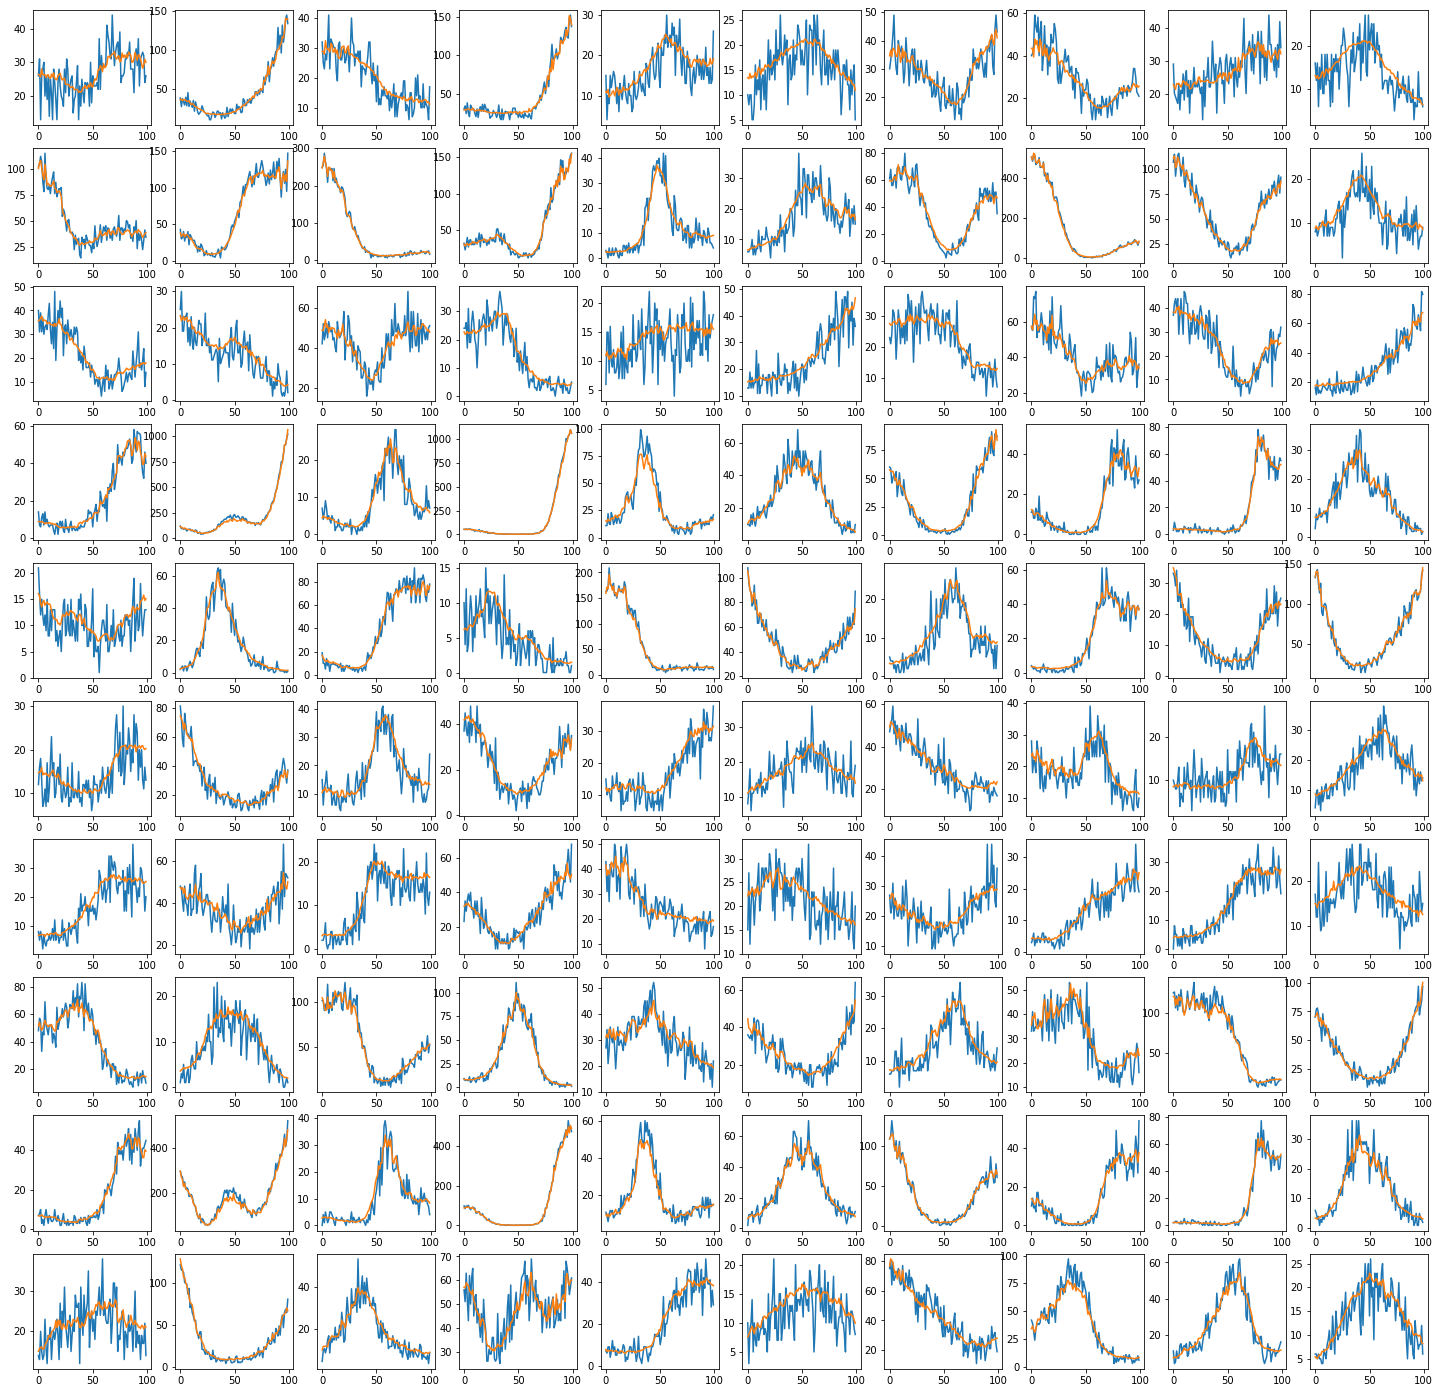

In [61]:
Y = tf.reshape(Y, (n, s*r))
Y_est = tf.Variable(np.zeros(shape = (n, s*r)))
for t in range( n):
   Y_est[t, :].assign(h(X_kalman[t+1, :], c[t, :]))


n_plots = 10
i = tf.random.uniform(shape = [n_plots], maxval = s, dtype = tf.int64)
j = tf.random.uniform(shape = [n_plots], maxval = r, dtype = tf.int64)
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( Y[:, i + j*r ])
    axs[ i, j].plot( Y_est[:, i + j*r ])




In [62]:
# fit a censored process
alpha = tf.constant(-3, dtype = np.float64)
Y = np.zeros((n, s, r))
for t in range(n):
  Y[t, :, :]= tfd.Poisson(log_rate = alpha + tf.matmul(X_true[t,:s,:], X_true[t,s:,:], transpose_b=True)).sample(1)

Y = tf.reshape(Y, (n, s*r))


censor_data = get_censoring(Y)
Y = Y*censor_data

train_dataset = tf.data.Dataset.from_tensor_slices((Y, censor_data))
train_dataset = train_dataset.batch(batch_size=1)

model_coefficients = alpha
c = tf.Variable(tf.fill((n, s*r), model_coefficients), trainable=False)


model = Kalman_model(x_0, Sigma)
for iter in range(10):
  train_kalman(model)
  train_smoother(model)
  model_coefficients, log_likelihood = fit_glm(tf.reshape(Z, (-1,1)), tf.reshape(Y, [-1]), tf.reshape(offset, [-1]), censor_data)
  c.assign(tf.fill((n, s*r), model_coefficients))
  tf.print("log likelihood = ", tf.reduce_sum(log_likelihood))


forward filtering
backward smoothing
log likelihood =  -1814.8953265413484
forward filtering
backward smoothing
log likelihood =  -1816.1929541395684
forward filtering
backward smoothing
log likelihood =  -1815.03695617818
forward filtering
backward smoothing
log likelihood =  -1814.3167315823077
forward filtering
backward smoothing
log likelihood =  -1813.74353221962
forward filtering
backward smoothing
log likelihood =  -1813.2267140899653
forward filtering
backward smoothing
log likelihood =  -1812.7369469121222
forward filtering
backward smoothing
log likelihood =  -1812.264366888425
forward filtering
backward smoothing
log likelihood =  -1811.8053678467061
forward filtering
backward smoothing
log likelihood =  -1811.358383798595


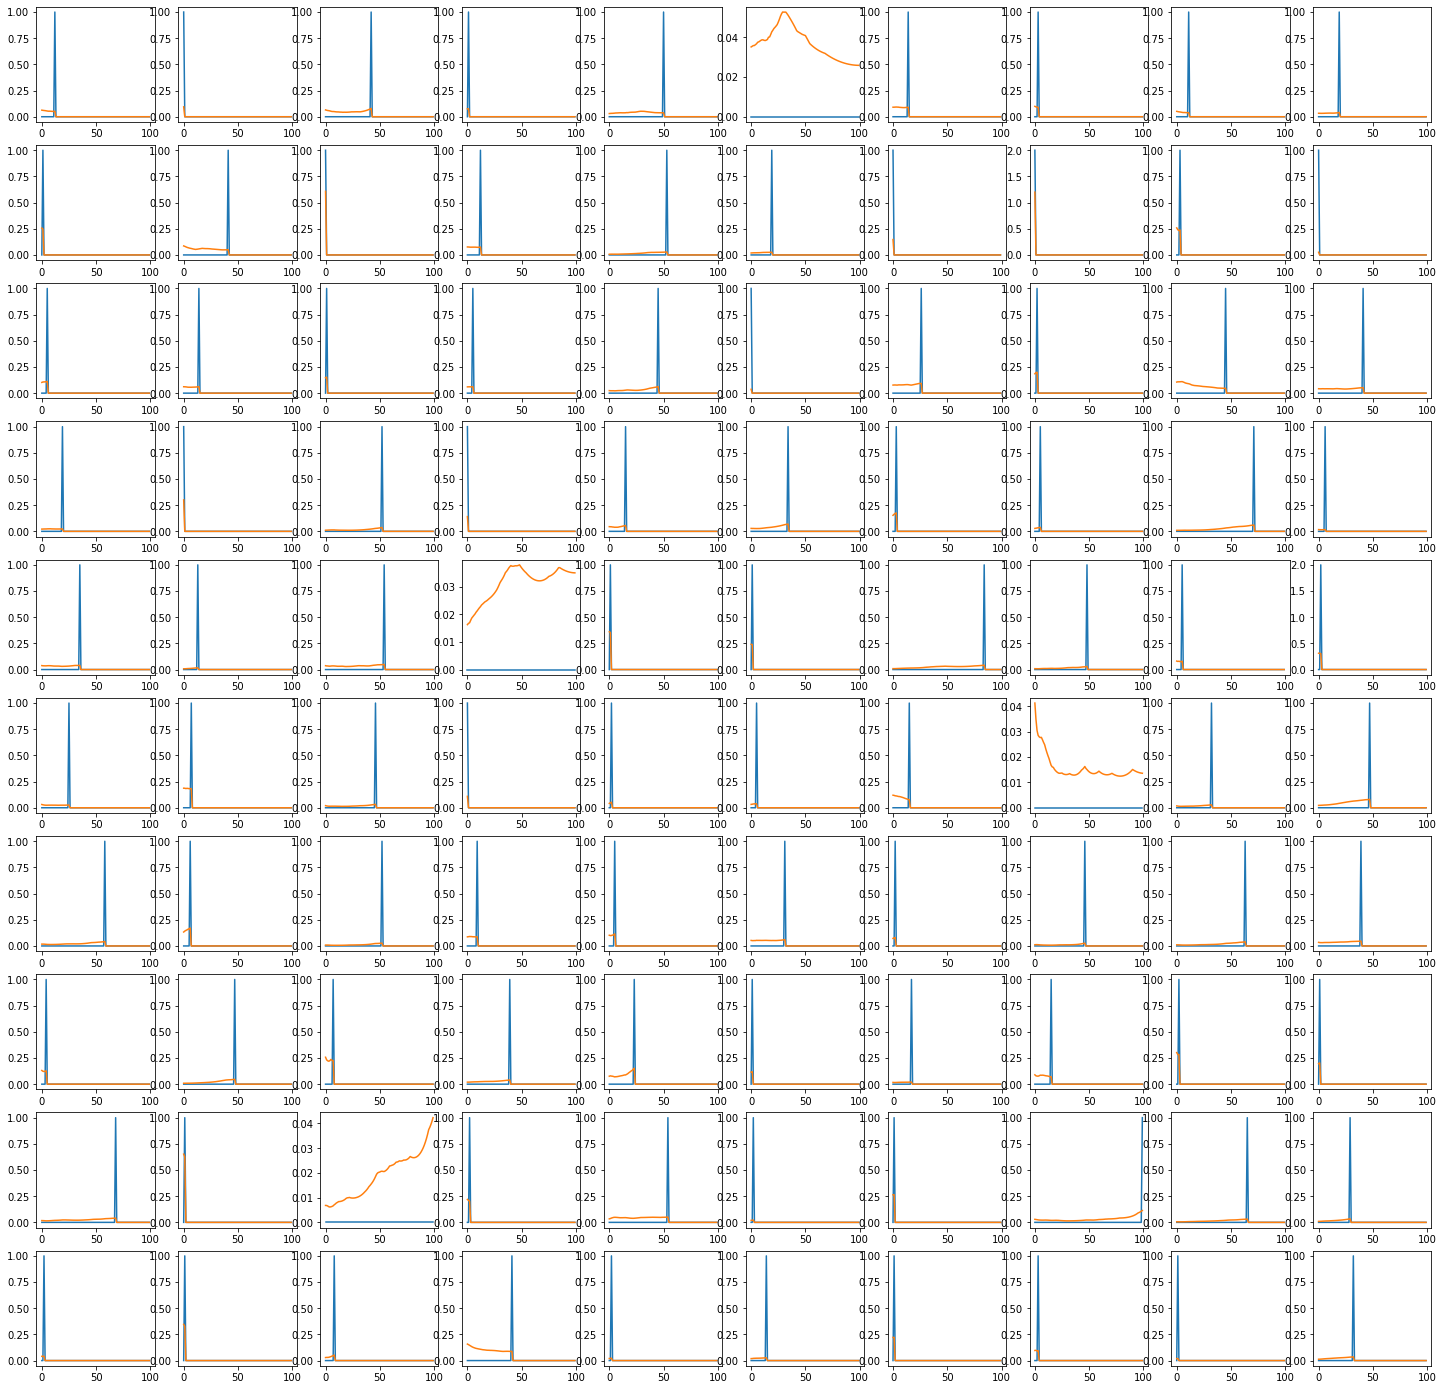

In [63]:
Y = tf.reshape(Y, (n, s*r))
Y_est = tf.Variable(np.zeros(shape = (n, s*r)))
for t in range( n):
   Y_est[t, :].assign(h(X_kalman[t+1, :], c[t, :]))

Y_est = Y_est*censor_data
n_plots = 10
i = tf.random.uniform(shape = [n_plots], maxval = s, dtype = tf.int64)
j = tf.random.uniform(shape = [n_plots], maxval = r, dtype = tf.int64)
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( Y[:, i + j*r ])
    axs[ i, j].plot( Y_est[:, i + j*r ])



In [ ]:
# particle filter should work well in GPU computing
# there is no bottleneck of matrix inversion

def h_b(x, c):
  species = tf.reshape(x[:(s*d)], (s, d))
  region = tf.reshape(x[(s*d):], (r, d))
  return tf.exp( c + tf.reshape(tf.matmul(species, region, transpose_b=True), [-1]))


def log_Poisson_Gaussian(y, x_new, x_old, c, sigma2):
  mu = h(x_new, c)
  return tf.reduce_sum(-mu + y * tf.math.log(mu) - tf.square(x_new - x_old)/(2*sigma2)  )
  

class Kalman_MonteCarlo_model(tf.Module):
  def __init__(self, x_0, Sigma):
    #super().__init__(**kwargs)
    self.x = tf.Variable(x_0)
    self.V = tf.Variable(Sigma)

  def __call__(self, y, c, censoring):
    self.V.assign_add(Sigma)


    if(censoring != None):
      censoring = tf.reshape(censoring, [-1])
       mu = mu * censoring
    self.x.assign( )
    self.V.assign( )
    return 

  def smoother(self, x_prev, V_prev):
    V_prior = V_prev + Sigma
    B = tf.matmul(V_prev, tf.linalg.inv(V_prior))
    self.x.assign(x_prev + tf.reshape(tf.matmul(B, tf.reshape(self.x - x_prev, (-1,1))), [-1]))
    V_tmp = V_prev + tf.matmul(tf.matmul(B, self.V - V_prior), B, transpose_b=True)
    self.V.assign( (V_tmp + tf.transpose(V_tmp))/2 )
    return 
